In [1]:
import os
os.chdir("../")

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from models.GCNmodel import *
from utils import *
from sklearn.decomposition import PCA
from mendeleev import element
import matplotlib.gridspec as gridspec
#plt.rcParams['font.family']='times new roman'

In [3]:
is_train=False

#task=[['lattice_constant','E0'],['Ef','stability']]
task=[['Mag']]
task_flatten=[]
for i in task:
    if isinstance(i,list):
        task_flatten+=i
    else:
        task_flatten.append(i)
task=[i if isinstance(i,list) else [i] for i in task]

device = torch.device('cpu')

#datasets=[elementtables_structure_new(task='E0',device=device),elementtables_structure_full_heusler(device=device)]
datasets=[elementtables_structure_new(task='Mag',device=device)]

ratio=[0.7,0.15,0.15]

RANDOM_SEED = 119
np.random.seed(RANDOM_SEED)

index=torch.ones((100),dtype=torch.int32)
for i in range(len(datasets)):
    if isinstance(ratio,float) or len(ratio)==2:
        train_mask,test_mask=random_split(len(datasets[i]),ratio)
        train_dataset,test_dataset=datasets[i][train_mask],datasets[i][test_mask]
        index=((index) & (torch.count_nonzero((train_dataset[0][:,0,:,:]>0).reshape(-1,100),dim=0)>50))
    else:
        train_mask,val_mask,test_mask=random_split(len(datasets[i]),ratio)
        train_dataset,val_dataset,test_dataset=datasets[i][train_mask],datasets[i][val_mask],datasets[i][test_mask]
        index=((index) & (torch.count_nonzero((train_dataset[0][:,0,:,:]>0).reshape(-1,100),dim=0)>50))

In [4]:
torch.count_nonzero((train_dataset[0][:,0,:,:]>0).reshape(-1,100),dim=0)

tensor([    0,     0,  9105,  8150,  1066,   118,    67,     0,     0,     0,
        10788,  9638,  8432,  1213,  1209,   105,  2544,     0, 13690, 10644,
        10537, 12436, 14002, 16607,     0, 17240, 18433,  9195,  8673,  9133,
         8925,  1446,  1296,  1730,  2387,     0,    15, 12334, 10584, 10548,
        11352, 11539, 10892,  9598,  9036,  9137,  9985, 10086,  9882,  9857,
         1438,  1743,     0,     0,     0, 13226, 10010,     3,     3,     3,
            0,     2,     0,    11,     0,     0,     0,     0,     0,     0,
            0,  9386, 10053, 10050,  9222,  8390,  8118,  9124,  9857, 10414,
        10703, 10863, 10415,     0,     0,     0,     0,     0,     0,     0,
            0,     3,     0,     0,     0,     0,     0,     0,     0,     0])

In [5]:
index

tensor([0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], dtype=torch.int32)

In [6]:
para_dict=torch.load("result/%s_model.pth"%('_'.join(task_flatten)))
embedding=para_dict['embedding.weight'].cpu().detach().numpy()

In [7]:
np.argmax(embedding),np.argmin(embedding)

(3448, 3303)

In [8]:
embedding.shape

(100, 56)

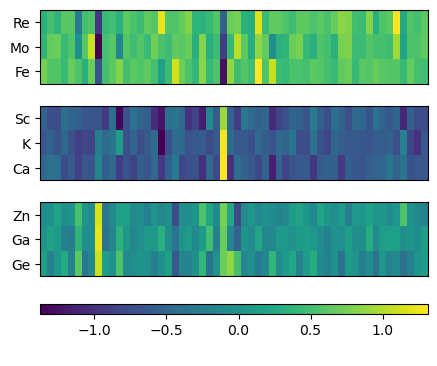

In [51]:
element_show_list=['Re','Mo','Fe','Sc','K','Ca','Zn','Ga','Ge']
element_show_arg=[np.argwhere(i==ChemicalSymbols)[0][0] for i in element_show_list]
#print(element_show_arg)
fig, ax = plt.subplots(figsize=(5,4.5))
gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1], hspace=0.3)
ax.axis('off')
# 绘制第一个子图
ax1 = fig.add_subplot(gs[0])
im1 = ax1.imshow(embedding[element_show_arg[0:3], :], aspect='auto', cmap='viridis')
ax1.set_yticks(range(3))
ax1.set_yticklabels(element_show_list[0:3])
ax1.set_xticks([])


# 绘制第二个子图
ax2 = fig.add_subplot(gs[1])
im2 = ax2.imshow(embedding[element_show_arg[3:6], :], aspect='auto', cmap='viridis')
ax2.set_yticks(range(3))
ax2.set_yticklabels(element_show_list[3:6])
ax2.set_xticks([])


# 绘制第三个子图
ax3 = fig.add_subplot(gs[2])
im3 = ax3.imshow(embedding[element_show_arg[6:], :], aspect='auto', cmap='viridis')
ax3.set_yticks(range(3))
ax3.set_yticklabels(element_show_list[6:])
ax3.set_xticks([])


# 添加共享的颜色条
cbar = fig.colorbar(im3, ax=[ax1, ax2, ax3], orientation='horizontal', pad=0.08,aspect=40)
cbar.mappable.set_clim(np.min(embedding[element_show_arg]), np.max(embedding[element_show_arg]))  # 设置 colorbar 的范围为 0 到 1

plt.savefig('result/element_embedding.jpg',dpi=2400)
plt.show()


In [11]:
X=embedding[index.numpy()>0]

In [12]:
pca=PCA(n_components=2)
pca_result=pca.fit_transform(X)

In [13]:
outer_e = []+4*['s'] \
    + 6*['p'] \
    + 2*['s'] \
    + 6*['p'] \
    + 2*['s'] \
    + 10*['d'] \
    + 6*['p'] \
    + 2*['s'] \
    + 10*['d'] \
    + 6*['p'] \
    + 2*['s'] \
    + 15*['f'] \
    + 9*['d'] \
    + 6*['p'] \
    + 2*['s'] \
    + 15*['f'] \
    + 9*['d'] 
outer_e_s=np.array(outer_e)[:100][index.numpy()>0]

color=['r','k','b','y']
c=[]
for i in range(len(outer_e)):
    if outer_e[i]=='s':
        c.append(color[0])
    elif outer_e[i]=='p':
        c.append(color[1])
    elif outer_e[i]=='d':
        c.append(color[2])
    elif outer_e[i]=='f':
        c.append(color[3])


c4colorbar=[]
for i in range(len(outer_e)):
    if outer_e[i]=='s':
        c4colorbar.append(1)
    elif outer_e[i]=='p':
        c4colorbar.append(2)
    elif outer_e[i]=='d':
        c4colorbar.append(3)
    elif outer_e[i]=='f':
        c4colorbar.append(4)
c4color_s=np.array(c4colorbar)[:100][index.numpy()>0]

In [14]:
c4colorbar[:100][index.numpy()>0]

TypeError: only integer scalar arrays can be converted to a scalar index

In [15]:
[index.numpy()>0]

[array([False, False,  True,  True,  True,  True,  True, False, False,
        False,  True,  True,  True,  True,  True,  True,  True, False,
         True,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,
        False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False, False,
        False,  True,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False])]

NameError: name 'outer_e1' is not defined

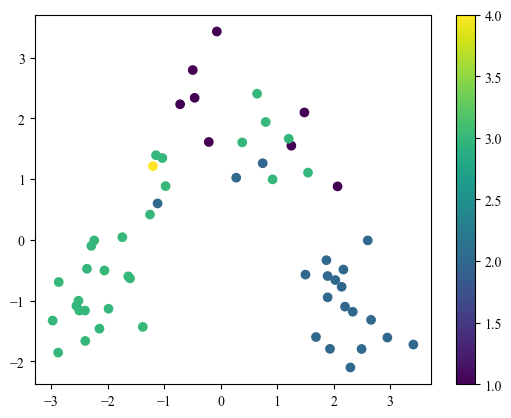

In [16]:
color=['r','k','b','y']
tag=['s','p','d','f']
elements=ChemicalSymbols[:100][index.numpy()>0]
plt.scatter(pca_result[:,0],pca_result[:,1],c=np.array(c4colorbar[:100])[index.numpy()>0],cmap='viridis')
plt.colorbar()
for j in range(len(set(c4colorbar))):
    args=outer_e1==tag[j]
    plt.scatter(pca_result[args, 0], pca_result[args, 1], c=color[j], label=tag[j])
for i in range(len(pca_result)):
    plt.text(pca_result[i,0],pca_result[i,1],elements[i])

In [25]:
print(element('C').ionic_radii)

[IonicRadius(
	atomic_number=6,
 	charge=4,
 	coordination='III',
 	crystal_radius=6.0,
 	econf='1s2',
 	id=56,
 	ionic_radius=-8.0,
 	most_reliable=False,
 	origin='',
 	spin='',
), IonicRadius(
	atomic_number=6,
 	charge=4,
 	coordination='IV',
 	crystal_radius=28.999999999999996,
 	econf='1s2',
 	id=57,
 	ionic_radius=15.0,
 	most_reliable=False,
 	origin="Pauling's (1960) crystal radius, ",
 	spin='',
), IonicRadius(
	atomic_number=6,
 	charge=4,
 	coordination='VI',
 	crystal_radius=30.0,
 	econf='1s2',
 	id=58,
 	ionic_radius=16.0,
 	most_reliable=False,
 	origin='Ahrens (1952) ionic radius, ',
 	spin='',
)]


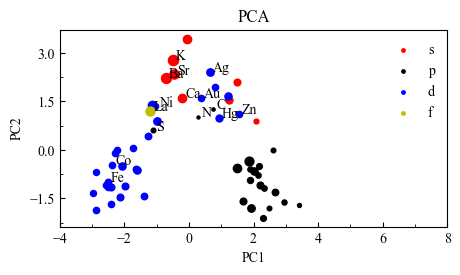

: 

In [18]:
color=['r','k','b','y']
tag=['s','p','d','f']
elements=ChemicalSymbols[:100][index.numpy()>0]

text_element=['C','N','S','K','Ca','La','Ba','Sr','Au','Ag','Zn','Hg','Fe','Co','Ni']

fig,axs=plt.subplots(1,1,figsize=(5,5))
for i,symbol in enumerate(elements):
    plt.scatter(pca_result[i,0],pca_result[i,1],\
                c=c[np.argwhere(ChemicalSymbols==symbol)[0][0]],s=(element(symbol).atomic_radius/30)**2)

for j in range(len(tag)):
    plt.scatter([], [], c=color[j], label=tag[j],s=6)

plt.legend(frameon=False,loc='upper right')

#plt.legend()
#plt.scatter(pca_result[:,0],pca_result[:,1],c=np.array(c4colorbar[:100])[index.numpy()>0],cmap='viridis')
#plt.colorbar()
#for j in range(len(set(c4colorbar))):
#    args=outer_e1==tag[j]
#    plt.scatter(pca_result[args, 0], pca_result[args, 1], c=color[j], label=tag[j])
for i in range(len(pca_result)):
    if elements[i] in text_element:
        plt.text(pca_result[i,0]+0.1,pca_result[i,1],elements[i])

axs.set_title('PCA')
axs.xaxis.set_major_locator(MaxNLocator(nbins=6))  # 设置X轴主刻度线数量为6
axs.yaxis.set_major_locator(MaxNLocator(nbins=6))
axs.xaxis.set_minor_locator(AutoMinorLocator(2))
axs.yaxis.set_minor_locator(AutoMinorLocator(2))
axs.tick_params(axis='both', direction='in')
axs.tick_params(axis='both', which='minor', direction='in')
axs.set_xlim(-4,8)
axs.set_xlabel('PC1')
axs.set_ylabel('PC2')
axs.set_aspect('equal')
#plt.savefig('result/PCA.png',dpi=2400)
#axs.legend(frameon=False)

In [23]:
elements=ChemicalSymbols[:100][index.numpy()>0]

In [24]:
elements

array(['Li', 'Be', 'B', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Sc', 'Ti',
       'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As',
       'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag',
       'Cd', 'In', 'Sn', 'Sb', 'Te', 'Ba', 'La', 'Hf', 'Ta', 'W', 'Re',
       'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi'], dtype='<U2')

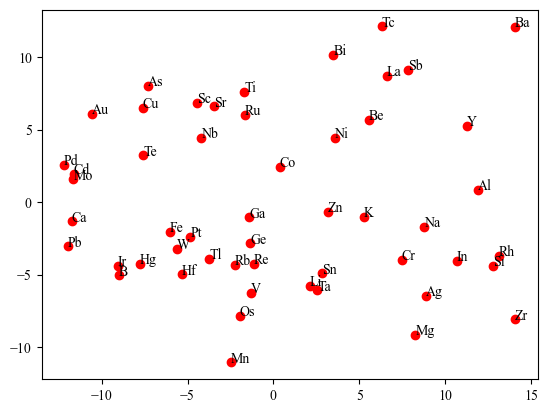

In [25]:
for i in range(len(pca_result)):
    plt.scatter(pca_result[i,0],pca_result[i,1],c='r')
    plt.text(pca_result[i,0],pca_result[i,1],elements[i])

In [27]:
tsne = TSNE(n_components=2, random_state=6)
X_tsne = tsne.fit_transform(X)

In [88]:
X_tsne.shape

(65, 2)

In [90]:
print(np.concatenate([np.array(ChemicalSymbols[args]).reshape(-1,1),np.array(c4colorbar).reshape(-1,1)],axis=1).reshape(-1))

['Li' 's' 'Be' 's' 'B' 'p' 'C' 'p' 'N' 'p' 'Na' 's' 'Mg' 's' 'Al' 'p' 'Si'
 'p' 'P' 'p' 'S' 'p' 'Cl' 'p' 'K' 's' 'Ca' 's' 'Sc' 'd' 'Ti' 'd' 'V' 'd'
 'Cr' 'd' 'Mn' 'd' 'Fe' 'd' 'Co' 'd' 'Ni' 'd' 'Cu' 'd' 'Zn' 'd' 'Ga' 'p'
 'Ge' 'p' 'As' 'p' 'Se' 'p' 'Br' 'p' 'Rb' 's' 'Sr' 's' 'Y' 'd' 'Zr' 'd'
 'Nb' 'd' 'Mo' 'd' 'Tc' 'd' 'Ru' 'd' 'Rh' 'd' 'Pd' 'd' 'Ag' 'd' 'Cd' 'd'
 'In' 'p' 'Sn' 'p' 'Sb' 'p' 'Te' 'p' 'Ba' 's' 'La' 'f' 'Ce' 'f' 'Pr' 'f'
 'Nd' 'f' 'Sm' 'f' 'Gd' 'f' 'Hf' 'd' 'Ta' 'd' 'W' 'd' 'Re' 'd' 'Os' 'd'
 'Ir' 'd' 'Pt' 'd' 'Au' 'd' 'Hg' 'd' 'Tl' 'p' 'Pb' 'p' 'Bi' 'p' 'U' 'f']


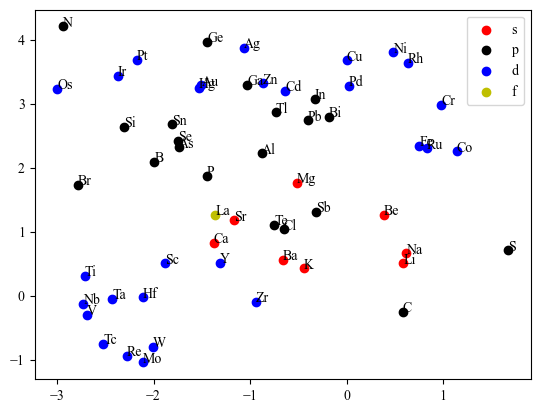

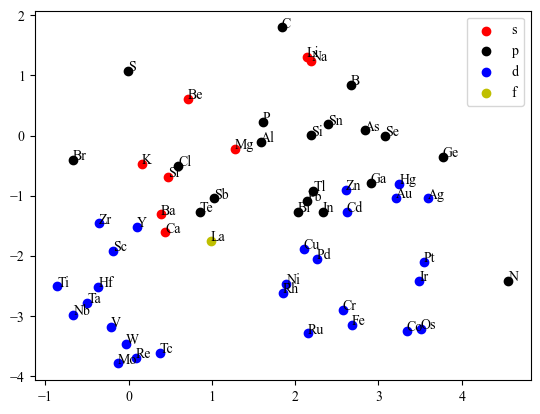

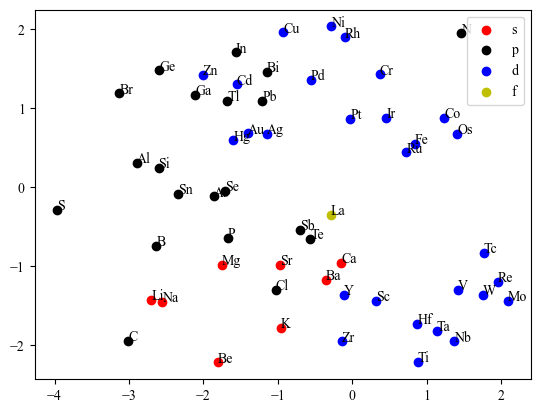

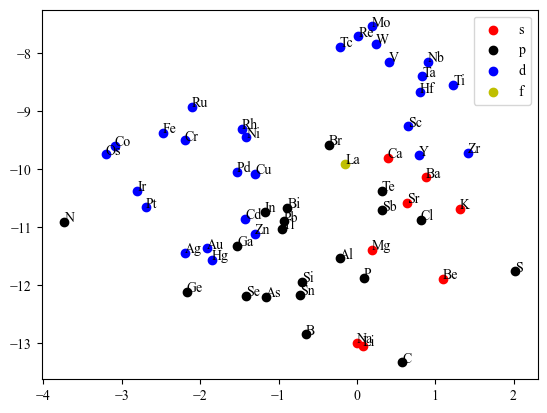

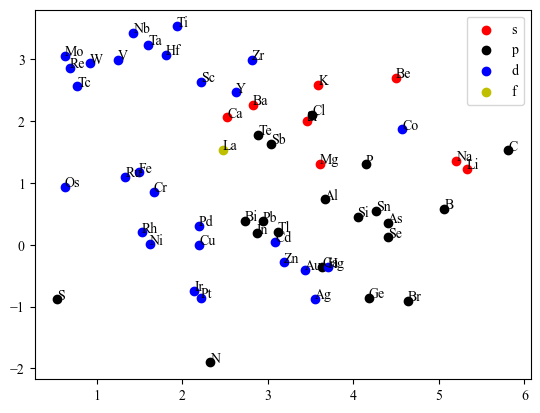

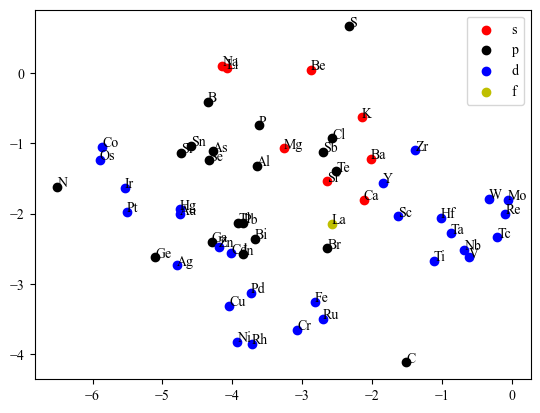

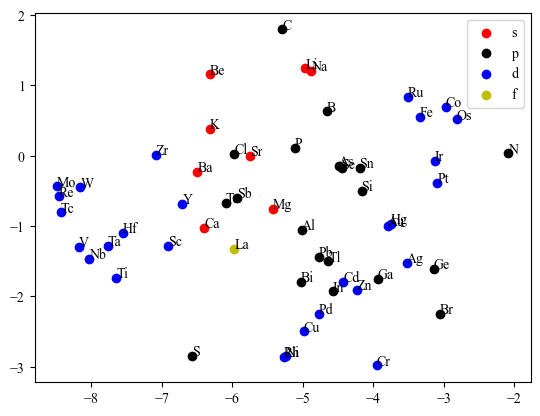

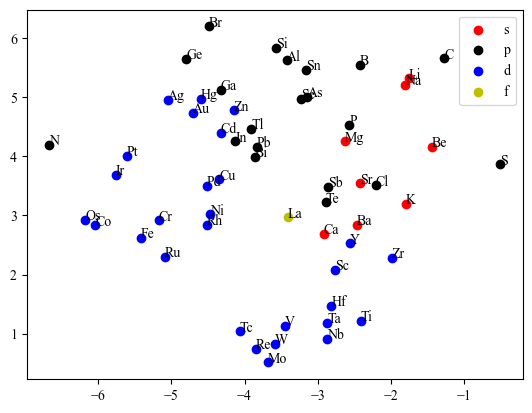

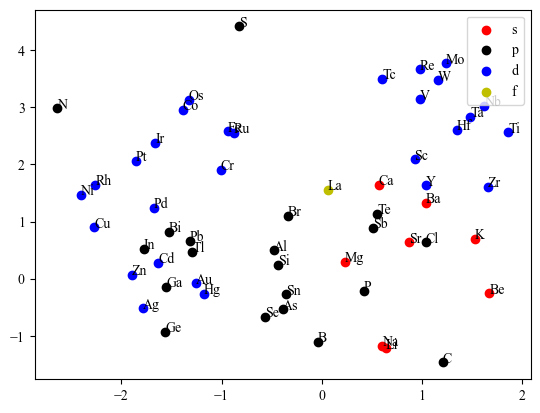

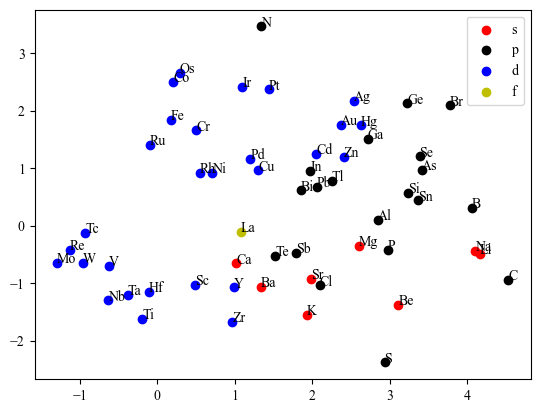

In [16]:
color=['r','k','b','y']
tag=['s','p','d','f']
for i in range(10):
    tsne = TSNE(n_components=2, random_state=i)
    X_tsne = tsne.fit_transform(X)
    for j in range(len(set(c4colorbar))):
        args=outer_e1==tag[j]
        plt.scatter(X_tsne[args, 0], X_tsne[args, 1], c=color[j], label=tag[j])
    plt.legend()
    for i in range(len(pca_result)):
        plt.text(X_tsne[i,0],X_tsne[i,1],elements[i])
    plt.show()

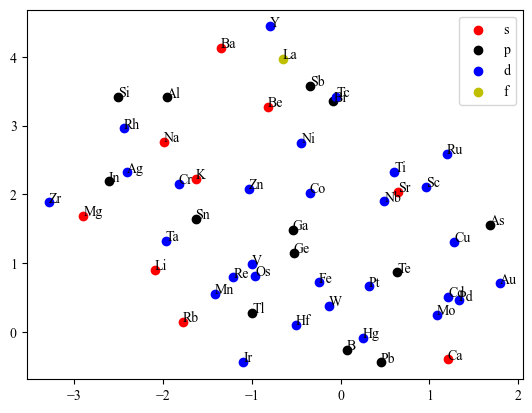

In [38]:
color=['r','k','b','y']
tag=['s','p','d','f']
for i in range(1):
    tsne = TSNE(n_components=2, random_state=i)
    X_tsne = tsne.fit_transform(X)
    for j in range(len(set(c4colorbar))):
        args=outer_e1==tag[j]
        plt.scatter(X_tsne[args, 0], X_tsne[args, 1], c=color[j], label=tag[j])
    plt.legend()
    for i in range(len(pca_result)):
        plt.text(X_tsne[i,0],X_tsne[i,1],elements[i])
    plt.show()

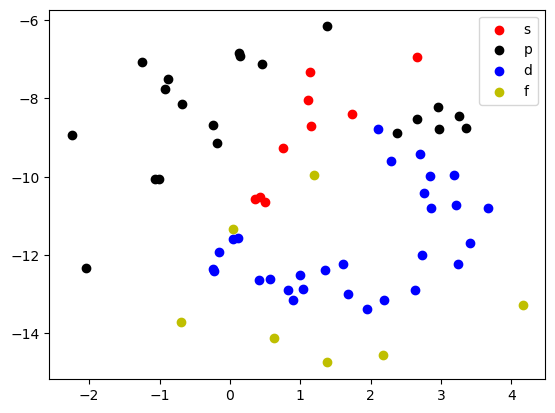

In [94]:
color=['r','k','b','y']
tag=['s','p','d','f']
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X)
for i in range(4):
    args=np.nonzero(np.array(c4colorbar)==tag[i])
    plt.scatter(X_tsne[args, 0], X_tsne[args, 1], c=color[i],label=tag[i])
plt.legend()
plt.show()

In [33]:
ChemicalSymbols[args][(np.abs(X_tsne[args, 0])<0.2) & (np.abs(X_tsne[args, 1])<0.2)]

array(['Ce'], dtype='<U2')

In [34]:
c4colorbar==1

False